In [5]:
import jax 
import jax.numpy as np 
import jax.random as npr 
import matplotlib.pyplot as plt 
import shapely 

import estimators 
import geometry_utils 

In [39]:
def segments_to_polygon(segments: np.ndarray) -> shapely.Polygon: 
    vertices: np.ndarray = segments[:, 0, :]
    return shapely.Polygon(vertices)

def rotation(theta: np.ndarray) -> np.ndarray: 
    return np.array([
        [np.cos(theta), -np.sin(theta)], 
        [np.sin(theta), np.cos(theta)], 
    ])

def transform_shape(params: tuple[np.ndarray], segments: np.ndarray) -> np.ndarray: 
    theta, translation = params
    mean: np.ndarray = segments.mean(0)
    R: np.ndarray = rotation(theta)
    out: np.ndarray = R[np.newaxis, ...] @ (segments - mean) + translation + mean 
    return out

def safe_norm(x: np.ndarray, **kwargs) -> np.ndarray: 
    return np.linalg.norm(x, **kwargs)

def fiberlen(fibers: np.ndarray) -> np.ndarray: 
    return safe_norm(fibers[..., 1] - fibers[..., 0], axis=-1).sum()

def polygon_to_segments(polygon: shapely.Polygon) -> np.ndarray: 
    boundary: np.ndarray = np.array(polygon.boundary.xy).T
    segments: np.ndarray = np.stack((boundary[:-1], boundary[1:]), axis=-1).transpose(0, 2, 1)
    return segments

def clip_to_segments(fibers: np.ndarray, segments: np.ndarray) -> np.ndarray: 
    # clip the fibers with respect to the line segments constituting the polygon 
    clips, endpoint_sides, has_intersections = geometry_utils.clip_wrt_wall(fibers, segments)
    clip: np.ndarray = geometry_utils._reduce_clip_params(clips)

    # determine if there are any intersections 
    any_intersections: np.ndarray = has_intersections.any(-1)

    is_fully_inside: np.ndarray = (endpoint_sides > 0).all((-1, -2))
    is_fully_outside: np.ndarray = np.logical_and(~is_fully_inside, ~any_intersections)
    
    # compute the clipping parameters
    clip_parameters: np.ndarray = jax.lax.select(is_fully_outside, np.zeros_like(clip), clip)
    
    # apply clipping 
    clipped_fiber: np.ndarray = geometry_utils.apply_fiber_clip(fibers, clip_parameters)
    return clipped_fiber

def clip_to_polygon(fibers: np.ndarray, polygon: shapely.Polygon) -> np.ndarray: 
    return clip_to_segments(fibers, polygon_to_segments(polygon))

def plot_fibers(fibers: np.ndarray, ax, **kwargs) -> None: 
    for fiber in fibers: 
        if kwargs.get("endpoints", True):
            ax.scatter(fiber[:, 0], fiber[:, 1], c="tab:red", s=20)
        ax.plot(fiber[:, 0], fiber[:, 1], c=kwargs.get("body_color", "tab:blue"), alpha=kwargs.get("alpha", 0.35))

def show_polygon(polygon: shapely.Polygon, ax, **kwargs) -> None: 
    ax.plot(*polygon.exterior.xy, c=kwargs.get("color", "tab:blue"))
    ax.fill_between(*polygon.exterior.xy, color=kwargs.get("color", "tab:blue"), alpha=0.2)

In [40]:
vertices: np.ndarray = np.array([
    [0., 0.], 
    [0.5, 0.3], 
    [1., 0.], 
    [0.7, 0.5], 
    [1., 1.], 
    [0.5, 0.7], 
    [0., 1.], 
    [0.3, 0.5], 
])
vertices_b: np.ndarray = np.array([
    [0.5, 0.5], 
    [1., 0.5], 
    [1., 1.], 
    [0.5, 1.], 
])

polygon = shapely.Polygon(vertices)
polygon_b = shapely.Polygon(vertices_b)

# sample fibers 
key: np.ndarray = npr.PRNGKey(0)
boundary_buffer: float = 0.
bounds: np.ndarray = np.array([0. - boundary_buffer, 0. - boundary_buffer, 1. + boundary_buffer, 1. + boundary_buffer])
num_fibers: int = 50
fiber_length: float = 0.2 
fibers: np.ndarray = estimators.sample(key, bounds, num_fibers, fiber_length)

In [41]:
def show(polygons: tuple[shapely.Polygon], fibers: np.ndarray): 
    polygon, polygonb = polygons 
    vector_clip: callable = jax.vmap(clip_to_segments, in_axes=(0, None))

    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    show_polygon(polygon, axs[0])
    show_polygon(polygonb, axs[0], color="tab:green")
    clipped: np.ndarray = vector_clip(fibers, polygon_to_segments(polygon))
    reduced_clipped = clipped[np.all(clipped[:, 1] != clipped[:, 0], axis=-1), ...]
    plot_fibers(reduced_clipped, axs[0], body_color="tab:red", endpoints=True, alpha=1.)


    show_polygon(polygon, axs[1])
    show_polygon(polygonb, axs[1], color="tab:green")
    doubly_clipped = vector_clip(clipped, polygon_to_segments(polygonb))
    reduced_clipped = doubly_clipped[np.all(doubly_clipped[:, 1] != doubly_clipped[:, 0], axis=-1), ...]
    plot_fibers(reduced_clipped, axs[1], body_color="tab:red", endpoints=True, alpha=1.)
    
    show_polygon(polygon, axs[2])
    show_polygon(polygonb, axs[2], color="tab:green")
    
    plt.xlim(-0.3, 1.3)
    plt.ylim(-0.3, 1.3)
    plt.xticks([])
    plt.yticks([])
    plt.show()

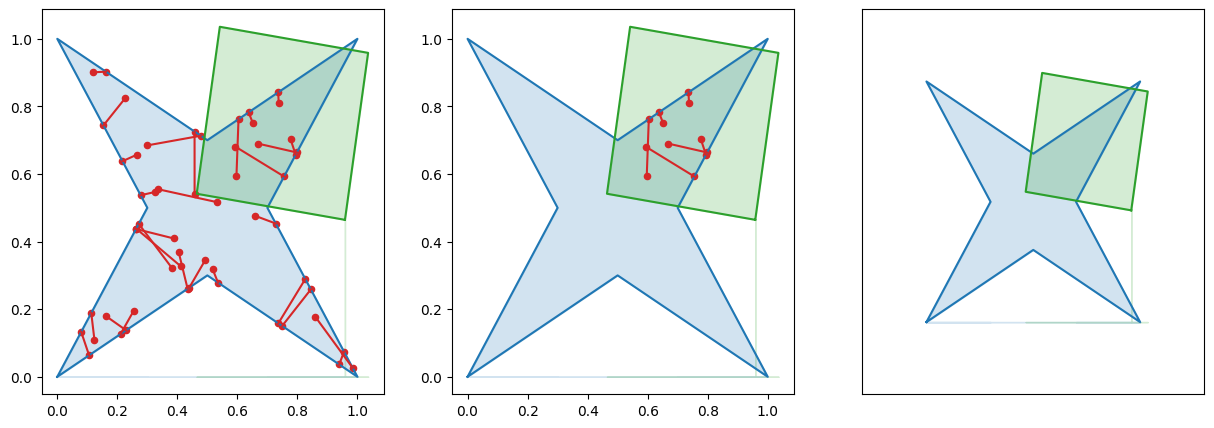

In [47]:
rotation_angle: np.ndarray = np.array(30.)
translation: np.ndarray = np.array([-0, -0])
params = (rotation_angle, translation)

transformed_polygon = segments_to_polygon(transform_shape(params, polygon_to_segments(polygon_b)))
polygons = (polygon, transformed_polygon)

show(polygons, fibers)

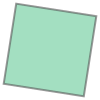